# Results

In [1]:
from os import makedirs
from os.path import join

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.legend import Legend


plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{cmbright}',
    'text.usetex': True,
    'font.family': 'serif',
})
color_palette = sns.color_palette('deep')
plt.rc('grid', linestyle="dotted", color='lightgrey')

results_dir = '../rpaper'
plots_dir = 'paper_plots'

arch_name = {
    'convnext-atto': 'ConvnextAtto',
    'convnext-tiny': 'ConvNextTiny',
    'convnextv2-atto': 'Convnextv2Atto',
    'convnextv2-nano': 'Convnextv2Nano',
    'convnextv2-tiny': 'Convnextv2Tiny',
    'densenet121': 'DenseNet121',
    'densenet161': 'DenseNet161',
    'mobilenetv3-small-075': 'MobileNetV3-Small-0.75',
    'mobilenetv3-large-100': 'MobileNetV3-Large-1.0',
    'mobilevitv2-050': 'MobileViTv2-0.5',
    'mobilevitv2-100': 'MobileViTv2-1.0',
    'mobilevitv2-200': 'MobileViTv2-2.0',

}

def format_pm(s: str) -> str:
    if isinstance(s, str) and '±' in s:
        return s.replace('±', '\\pm')
    else:
        return s

makedirs(plots_dir, exist_ok=True)

### Task Complexity

In [ ]:
# TODO

### Subpopulation Shift

In [2]:
def load_age_df():
    df = pd.read_csv(join(results_dir, 'shift_pop', 'exp_mtst.csv'))
    df = df[df.run.str.startswith('age_decade')]
    df['Decade'] = df['run'].str.split('_', expand=True)[1].str[6:].astype(int)
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']
    df = df[['Decade', 'Seen',  'Unseen', 'HM']]
    return df

age_df = load_age_df()
age_df


,Decade,Seen,Unseen,HM
0,2,82.55±0.12,89.20±0.15,85.48±0.12
1,3,83.56±0.14,88.92±0.20,85.57±0.14
2,4,84.89±0.12,88.81±0.20,86.34±0.13
3,5,84.66±0.12,88.93±0.18,86.31±0.12
4,6,84.75±0.13,85.49±0.23,84.51±0.15
5,7,84.73±0.13,82.53±0.28,82.70±0.19
6,8,84.24±0.16,79.37±0.38,79.77±0.28


Figure(640x480)


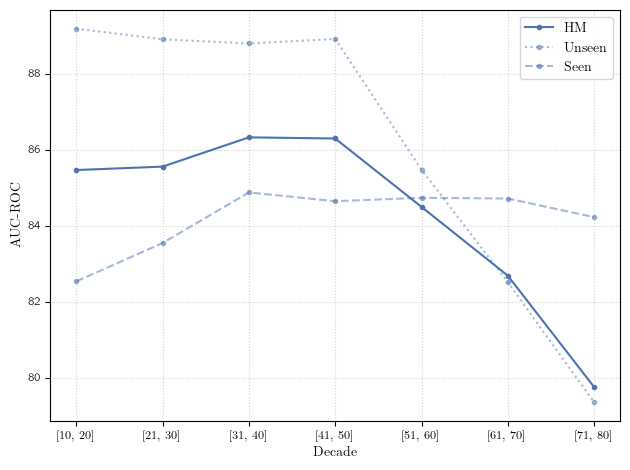

<Figure size 640x480 with 0 Axes>

In [3]:
def generate_age_plot(df: pd.DataFrame):
    df = df.copy()
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['HM'] = df['HM'].str[:5].astype(float)

    fig, ax = plt.subplots()
    ax: Axes = ax
    print(plt.figure())

    df.plot(
        x='Decade', y='HM',
        ax=ax,
        marker='.', linestyle='solid',
        color=color_palette[0]
    )

    df.plot(
        x='Decade', y='Unseen',
        ax=ax,
        marker='.', linestyle='dotted',
        alpha=0.5, color=color_palette[0]
    )

    df.plot(
        x='Decade', y='Seen',
        ax=ax,
        marker='.', linestyle='dashed',
        alpha=0.5, color=color_palette[0]
    )

    labels = ['[10, 20]', '[21, 30]', '[31, 40]', '[41, 50]',
              '[51, 60]', '[61, 70]', '[71, 80]']
    ax.set_xticks(range(2, 9), labels)
    ax.set_xlabel('Decade')
    ax.set_ylabel('AUC-ROC')

    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')

    ax.grid()
    fig.tight_layout()
    fig.savefig(join(plots_dir, 'subpop_age.pdf'))


generate_age_plot(age_df)

### Resolution

In [ ]:
# TODO

### Architectures

In [4]:
# TODO